In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import statistics
import pickle

In [64]:
traffic_pdf = pd.read_csv("traffic.csv")

In [65]:
traffic_pdf

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        None   59.23      0.0      0.0             40       Clouds   
1        None   61.18      0.0      0.0             75       Clouds   
2        None   61.57      0.0      0.0             90       Clouds   
3        None   62.56      0.0      0.0             90       Clouds   
4        None   64.38      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                 date_time  traffic_volume  
0      2012-10-02 09:00:00            5545  
1      2012-10-02 10:00:00            4516  
2      2012-10-02 11:00:00            4767  
3      2012-10-02 12:00:00            5026  
4      2012-10-02 13:00:00            4918  
...                    ...             ...  
43707  2018-04-30 19:00:00            3259  
43708  2018-04-30 20:00:00            2673  
43709  2018-04-30 21:00:00            2329  
43710  2018-04-30 22:00:00            1594  
43711  2018-04-30 23:00:00            1061  

[43712 rows x 8 columns]

In [66]:
traffic_pdf.dtypes

holiday            object
temp_F            float64
rain_mm           float64
snow_mm           float64
cloud_cover_%       int64
weather_type       object
date_time          object
traffic_volume      int64
dtype: object

In [67]:
#look at summary statistics for numerical values
#temp, cloud cover and traffic volume look pretty normal, no need to transform
#rain and snow look very long-headed
# attempted log transform to better see correlation with target
# still mostly 0 --> map to categorical variable
traffic_pdf.describe()

temp_F       rain_mm       snow_mm  cloud_cover_%  traffic_volume
count  43712.000000  43712.000000  43712.000000   43712.000000    43712.000000
mean      44.253533      0.346471      0.000245      49.898632     3251.521161
std       23.919416     47.033512      0.008577      39.041794     1989.021918
min     -459.670000      0.000000      0.000000       0.000000        0.000000
25%       28.760000      0.000000      0.000000       1.000000     1180.000000
50%       44.130000      0.000000      0.000000      64.000000     3360.000000
75%       63.450000      0.000000      0.000000      90.000000     4933.000000
max       95.160000   9831.300000      0.510000     100.000000     7280.000000

In [68]:
traffic_pdf['date_time'] = pd.to_datetime(traffic_pdf['date_time'])

In [69]:
traffic_pdf.dtypes

holiday                   object
temp_F                   float64
rain_mm                  float64
snow_mm                  float64
cloud_cover_%              int64
weather_type              object
date_time         datetime64[ns]
traffic_volume             int64
dtype: object

In [70]:
traffic_pdf['year'] = pd.DatetimeIndex(traffic_pdf['date_time']).year
traffic_pdf['month'] = pd.DatetimeIndex(traffic_pdf['date_time']).month
traffic_pdf['hod'] = pd.DatetimeIndex(traffic_pdf['date_time']).hour
traffic_pdf['dow'] = pd.DatetimeIndex(traffic_pdf['date_time']).dayofweek

In [71]:
traffic_pdf

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        None   59.23      0.0      0.0             40       Clouds   
1        None   61.18      0.0      0.0             75       Clouds   
2        None   61.57      0.0      0.0             90       Clouds   
3        None   62.56      0.0      0.0             90       Clouds   
4        None   64.38      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  hod  dow  
0     2012-10-02 09:00:00            5545  2012     10    9    1  
1     2012-10-02 10:00:00            4516  2012     10   10    1  
2     2012-10-02 11:00:00            4767  2012     10   11    1  
3     2012-10-02 12:00:00            5026  2012     10   12    1  
4     2012-10-02 13:00:00            4918  2012     10   13    1  
...                   ...             ...   ...    ...  ...  ...  
43707 2018-04-30 19:00:00            3259  2018      4   19    0  
43708 2018-04-30 20:00:00            2673  2018      4   20    0  
43709 2018-04-30 21:00:00            2329  2018      4   21    0  
43710 2018-04-30 22:00:00            1594  2018      4   22    0  
43711 2018-04-30 23:00:00            1061  2018      4   23    0  

[43712 rows x 12 columns]

(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text xticklabel objects>)

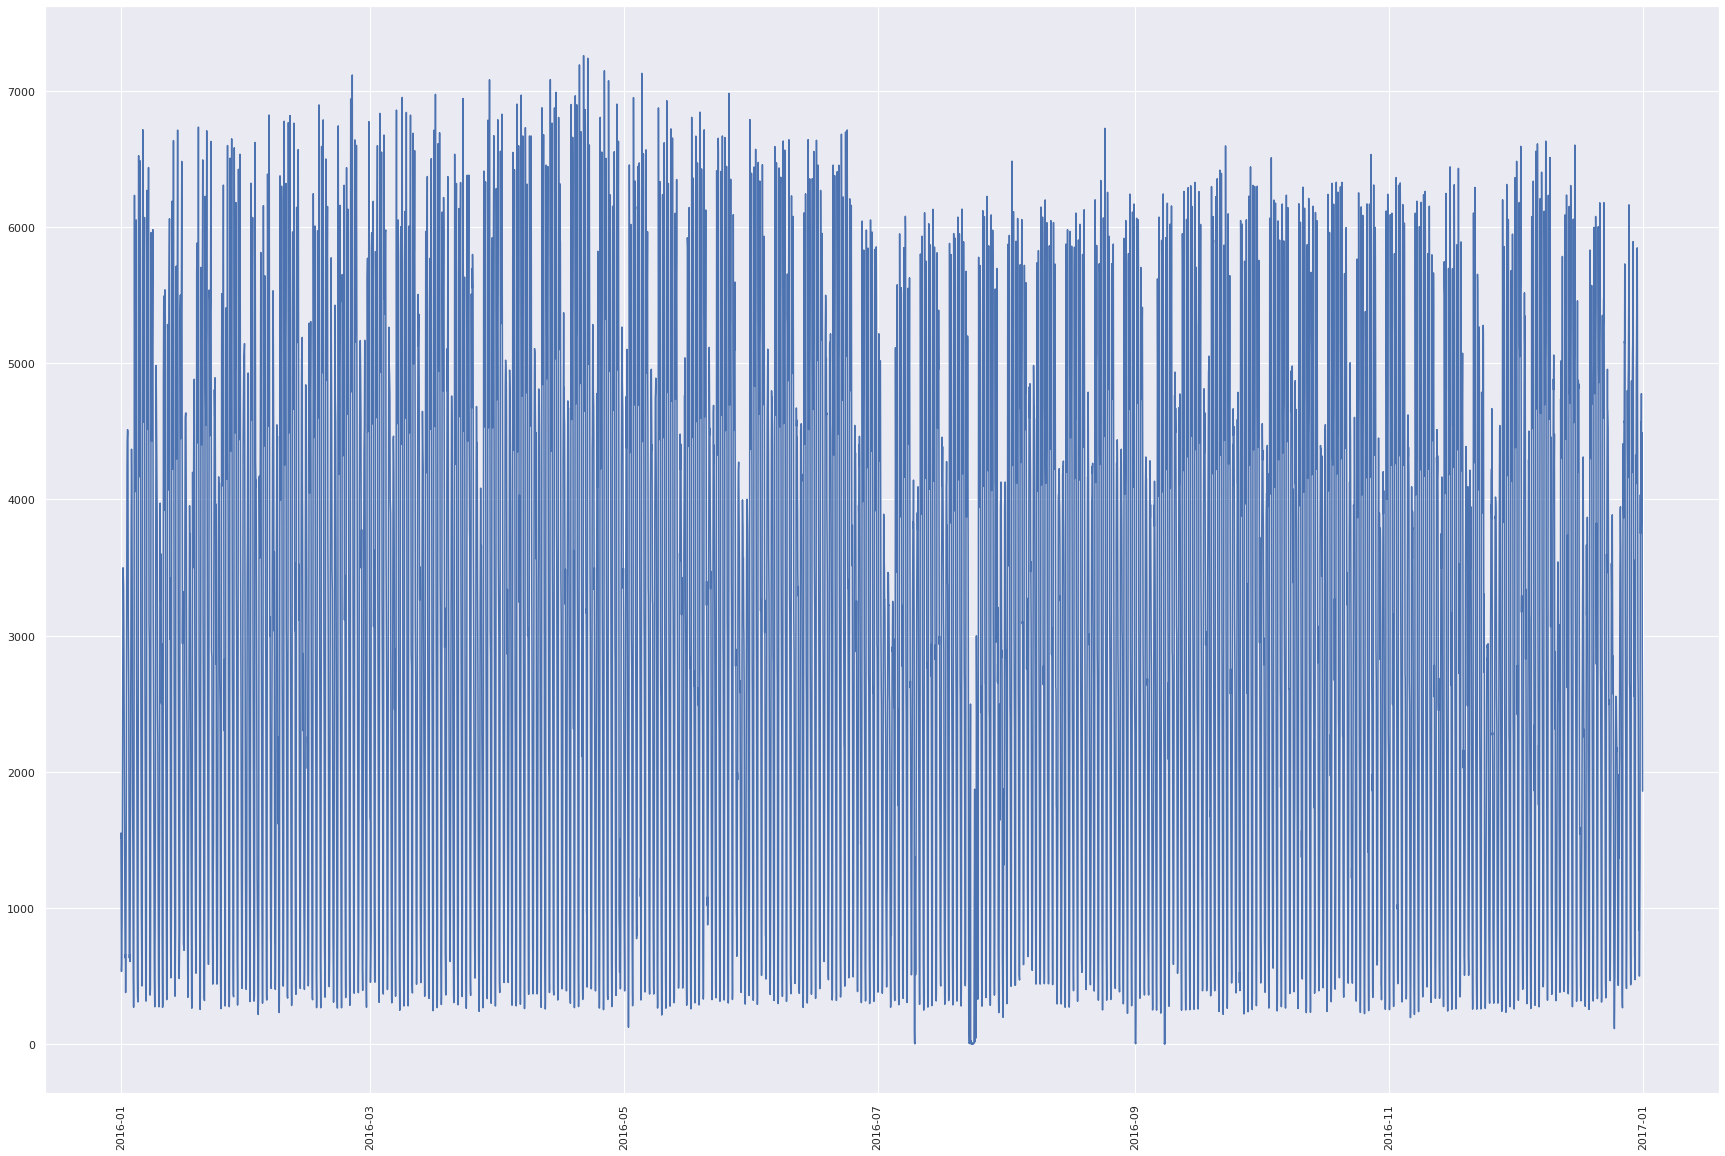

In [72]:
#plot time vs volume, get an idea for the time series
fig = plt.figure(figsize=(30,20))
traffic_pdf_sample = traffic_pdf[traffic_pdf['year']==2016]
plt.plot(traffic_pdf_sample['date_time'], traffic_pdf_sample['traffic_volume'])
plt.xticks(rotation='vertical')
#display(fig)

In [73]:
traffic_pdf['weather_type'].value_counts()

Clouds          14004
Clear           12227
Mist             5365
Rain             4767
Snow             2876
Drizzle          1589
Haze             1256
Fog               821
Thunderstorm      785
Smoke              18
Squall              4
Name: weather_type, dtype: int64

In [74]:
traffic_pdf['holiday'].value_counts()

None                         43656
Christmas Day                    6
Thanksgiving Day                 6
Martin Luther King Jr Day        6
New Years Day                    6
Labor Day                        5
Washingtons Birthday             5
Veterans Day                     5
Columbus Day                     5
Memorial Day                     4
Independence Day                 4
State Fair                       4
Name: holiday, dtype: int64

In [75]:
#create cutoffs based on distribution
def weather_categorizer(weather_df):
    if (weather_df['weather_type']!='Clouds') and (weather_df['weather_type']!='Clear'):
        return 'other'
    return weather_df['weather_type']

def rain_categorizer(rain_df):
    if (rain_df['rain_mm'] == 0):
        return "Level 0"
    return "Level 1"
    
def snow_categorizer(snow_df):
    if (snow_df['snow_mm'] == 0):
        return "Level 0"
    return "Level 1"

In [76]:
traffic_pdf['rain_level'] = traffic_pdf.apply(rain_categorizer, axis=1)
traffic_pdf['snow_level'] = traffic_pdf.apply(snow_categorizer, axis=1)
traffic_pdf['weather_type'] = traffic_pdf.apply(weather_categorizer, axis=1)

In [77]:
# Categorical variables highly imbalanced. Let's make sure to split them evenly across train and test set
traffic_pdf['rain_level'].value_counts()

Level 0    40958
Level 1     2754
Name: rain_level, dtype: int64

In [78]:
traffic_pdf['snow_level'].value_counts()

Level 0    43649
Level 1       63
Name: snow_level, dtype: int64

In [79]:
#add aggregate features for traffic at precipitation
traffic_df = traffic_pdf.sort_values('date_time')

In [80]:
traffic_df

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        None   59.23      0.0      0.0             40       Clouds   
1        None   61.18      0.0      0.0             75       Clouds   
2        None   61.57      0.0      0.0             90       Clouds   
3        None   62.56      0.0      0.0             90       Clouds   
4        None   64.38      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  hod  dow rain_level  \
0     2012-10-02 09:00:00            5545  2012     10    9    1    Level 0   
1     2012-10-02 10:00:00            4516  2012     10   10    1    Level 0   
2     2012-10-02 11:00:00            4767  2012     10   11    1    Level 0   
3     2012-10-02 12:00:00            5026  2012     10   12    1    Level 0   
4     2012-10-02 13:00:00            4918  2012     10   13    1    Level 0   
...                   ...             ...   ...    ...  ...  ...        ...   
43707 2018-04-30 19:00:00            3259  2018      4   19    0    Level 0   
43708 2018-04-30 20:00:00            2673  2018      4   20    0    Level 0   
43709 2018-04-30 21:00:00            2329  2018      4   21    0    Level 0   
43710 2018-04-30 22:00:00            1594  2018      4   22    0    Level 0   
43711 2018-04-30 23:00:00            1061  2018      4   23    0    Level 0   

      snow_level  
0        Level 0  
1        Level 0  
2        Level 0  
3        Level 0  
4        Level 0  
...          ...  
43707    Level 0  
43708    Level 0  
43709    Level 0  
43710    Level 0  
43711    Level 0  

[43712 rows x 14 columns]

In [81]:
categorical_cols_imbalanced = ['rain_level','snow_level','holiday'] 
categorical_cols_other = ['weather_type'] 
ordinal_cols = ['hod','dow']

In [82]:
#feature importance suggests we keep the following aggregate feature patterns
#lag_h
#lag_hodh
#l7_hodh
#l4_hod_dow
#avg_to_date
#min_to_date
for col in categorical_cols_imbalanced + categorical_cols_other + ordinal_cols:
    traffic_df[col+'_vol_avg_to_date'] = traffic_df.groupby(col,as_index=False)['traffic_volume'].shift().expanding().mean().reset_index(level=0, drop=True)


In [83]:
traffic_df

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        None   59.23      0.0      0.0             40       Clouds   
1        None   61.18      0.0      0.0             75       Clouds   
2        None   61.57      0.0      0.0             90       Clouds   
3        None   62.56      0.0      0.0             90       Clouds   
4        None   64.38      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  hod  dow rain_level  \
0     2012-10-02 09:00:00            5545  2012     10    9    1    Level 0   
1     2012-10-02 10:00:00            4516  2012     10   10    1    Level 0   
2     2012-10-02 11:00:00            4767  2012     10   11    1    Level 0   
3     2012-10-02 12:00:00            5026  2012     10   12    1    Level 0   
4     2012-10-02 13:00:00            4918  2012     10   13    1    Level 0   
...                   ...             ...   ...    ...  ...  ...        ...   
43707 2018-04-30 19:00:00            3259  2018      4   19    0    Level 0   
43708 2018-04-30 20:00:00            2673  2018      4   20    0    Level 0   
43709 2018-04-30 21:00:00            2329  2018      4   21    0    Level 0   
43710 2018-04-30 22:00:00            1594  2018      4   22    0    Level 0   
43711 2018-04-30 23:00:00            1061  2018      4   23    0    Level 0   

      snow_level  rain_level_vol_avg_to_date  snow_level_vol_avg_to_date  \
0        Level 0                         NaN                         NaN   
1        Level 0                 5545.000000                 5545.000000   
2        Level 0                 5030.500000                 5030.500000   
3        Level 0                 4942.666667                 4942.666667   
4        Level 0                 4963.500000                 4963.500000   
...          ...                         ...                         ...   
43707    Level 0                 3251.698325                 3251.590834   
43708    Level 0                 3251.698492                 3251.591004   
43709    Level 0                 3251.685252                 3251.577766   
43710    Level 0                 3251.664142                 3251.556659   
43711    Level 0                 3251.626218                 3251.518737   

       holiday_vol_avg_to_date  weather_type_vol_avg_to_date  \
0                          NaN                           NaN   
1                  5545.000000                   5545.000000   
2                  5030.500000                   5030.500000   
3                  4942.666667                   4942.666667   
4                  4963.500000                   4963.500000   
...                        ...                           ...   
43707              3252.211942                   3251.566320   
43708              3252.212097                   3251.566490   
43709              3252.198842                   3251.553252   
43710              3252.177716                   3251.594033   
43711              3252.139771                   3251.556110   

       hod_vol_avg_to_date  dow_vol_avg_to_date  
0                      NaN                  NaN  
1                      NaN          5545.000000  
2                      NaN          5030.500000  
3                      NaN          4942.666667  
4                      NaN          4963.500000  
...                    ...                  ...  
43707          3251.431462          3251.870117  
43708          3251.426302          3251.870281  
43709          3251.406057          3251.857035  
43710          3251.37

In [84]:
#inspect correlations between numerical cols
ordinal_cols_other = ['year','month']
mapped_categorical_cols = ['rain_mm','snow_mm']
numeric_cols = traffic_df.select_dtypes([np.number]).columns
non_ordinal_cols_0 = [x for x in numeric_cols if x not in ordinal_cols + ordinal_cols_other + mapped_categorical_cols]

In [85]:
non_ordinal_cols_0

['temp_F',
 'cloud_cover_%',
 'traffic_volume',
 'rain_level_vol_avg_to_date',
 'snow_level_vol_avg_to_date',
 'holiday_vol_avg_to_date',
 'weather_type_vol_avg_to_date',
 'hod_vol_avg_to_date',
 'dow_vol_avg_to_date']

In [86]:
len(non_ordinal_cols_0)

9

In [87]:
traffic_df_sample = traffic_df[traffic_df['year']==2016]

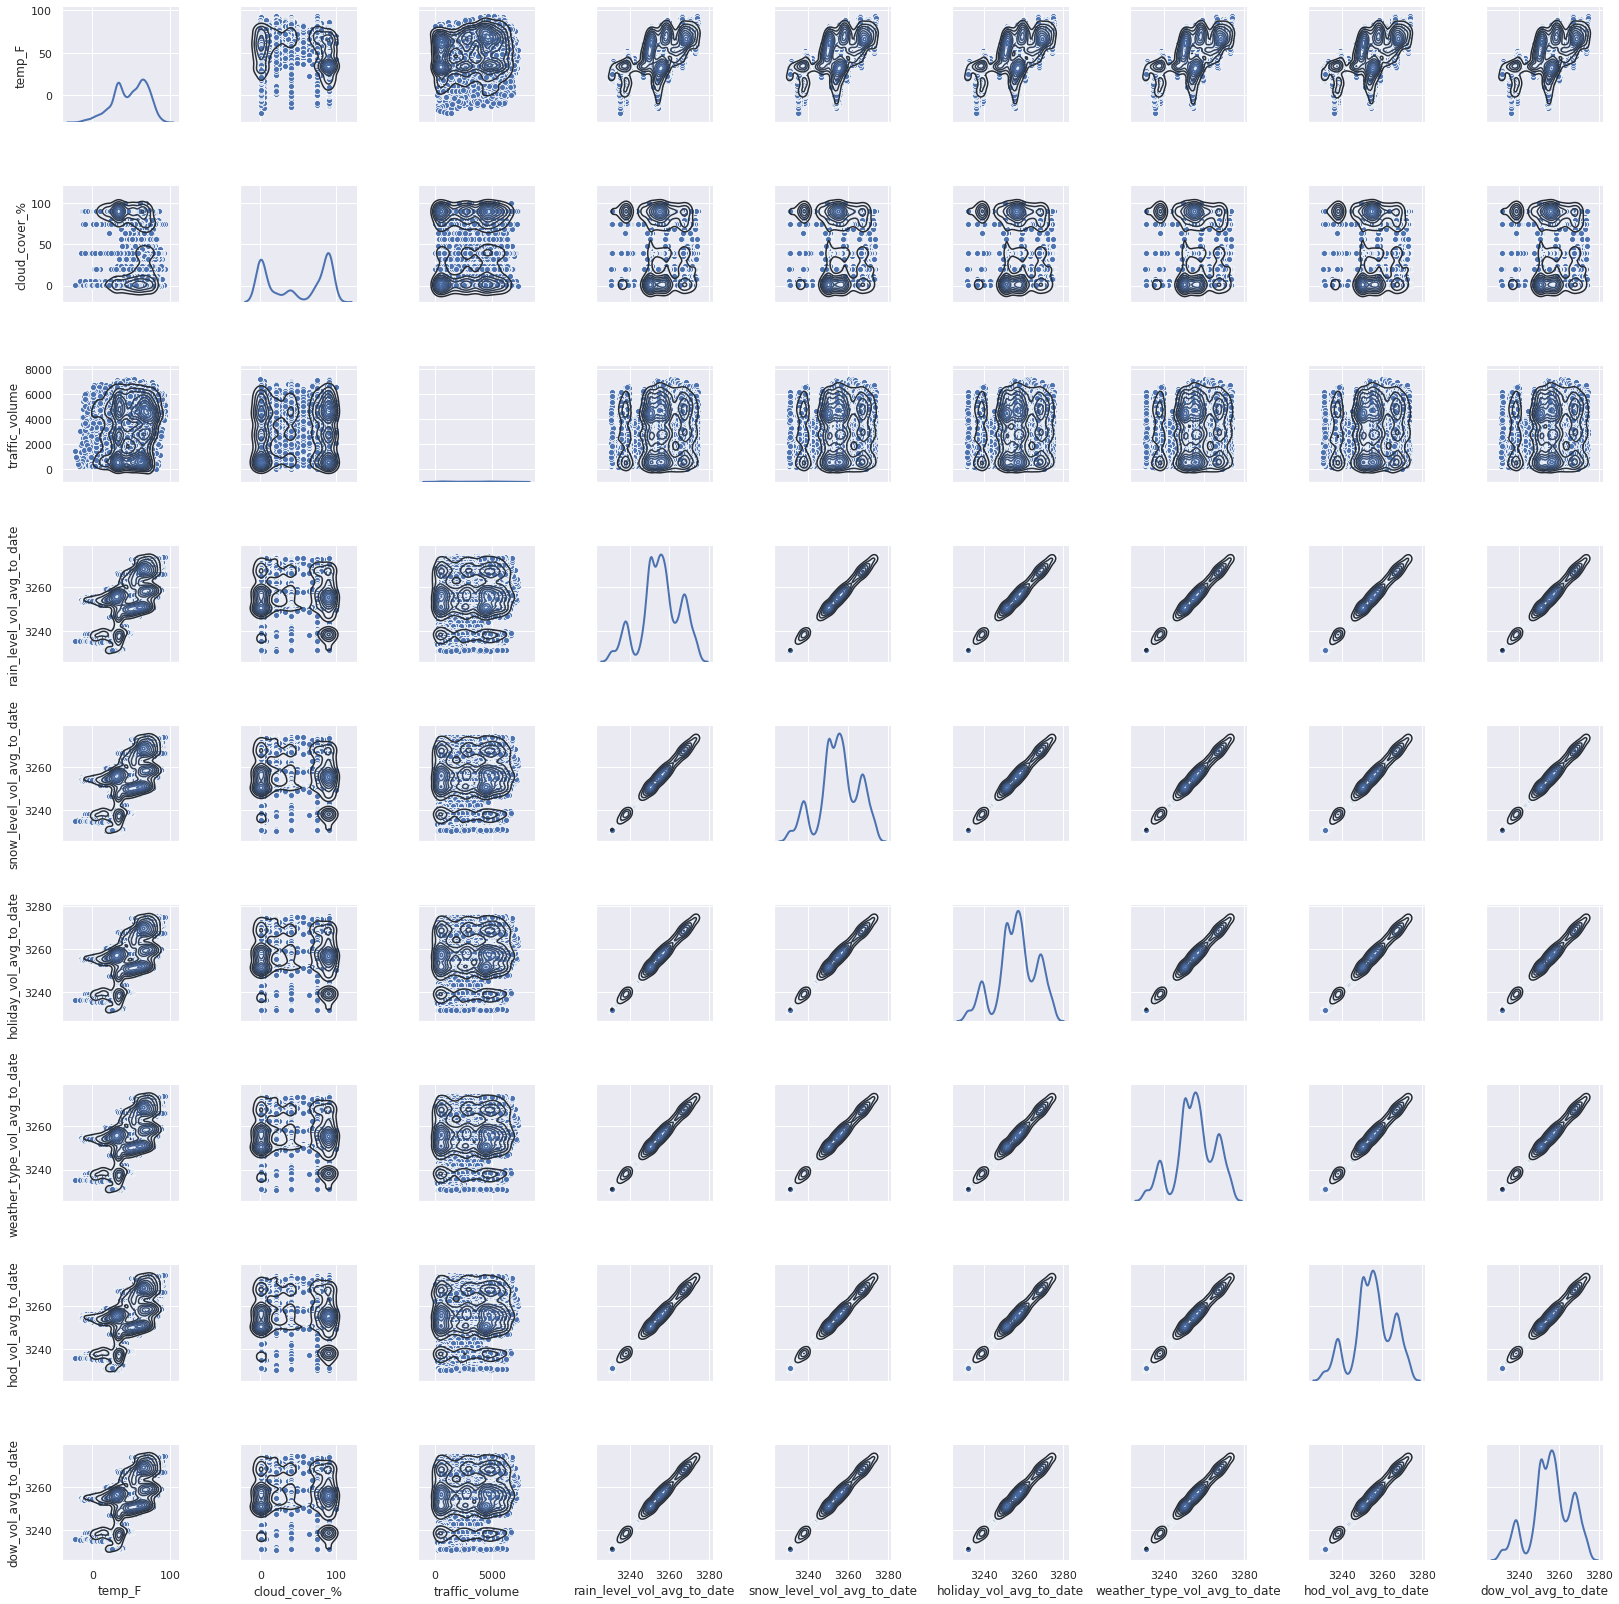

In [88]:
sns.set()
g = sns.PairGrid(traffic_df_sample[non_ordinal_cols_0])
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.scatterplot)
g = g.map_upper(sns.kdeplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=2)

In [89]:
for col in categorical_cols_imbalanced + categorical_cols_other + ordinal_cols:
    traffic_df[col+'_vol_max_to_date'] = traffic_df.groupby(col,as_index=False)['traffic_volume'].shift().expanding().max().reset_index(level=0, drop=True)
    traffic_df[col+'_vol_min_to_date'] = traffic_df.groupby(col,as_index=False)['traffic_volume'].shift().expanding().min().reset_index(level=0, drop=True)


In [90]:
# we see hod has strong correlation even when averaged over all time
# aggregate categories now with smaller windows
# remove monthly effect, covariate with temperature
#feature importance suggests we keep the following aggregate feature patterns
#lag_h
#lag_hodh
#l7_hodh
#l4_hod_dow
#avg_to_date
#min_to_date

order_window_dict = {'hod': [7],'dow':[24]}
def ordinal_aggregator(df, order_window_dict):
    for order, windows in order_window_dict.items():
        for window in windows:
            if order == 'hod':
                # volume at last hod
                df['vol_lag_'+str(order)+'h'] = df['traffic_volume'].shift(24)
                # min over last 7 hod
                df['vol_min_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).min().reset_index(level=0, drop=True)
                # max over last 7 hod
                df['vol_max_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).max().reset_index(level=0, drop=True)
                # avg over last 7 hod
                df['vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
                # std over last 7 hod
                df['vol_std_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).std().reset_index(level=0, drop=True)
            #if order == 'dow':
                # avg over 24 dowh previous to current
                #df['vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift(window).rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
    return df
    
def category_aggregator(df, category, order_window_dict):
    for order, windows in order_window_dict.items():
        for window in windows:
            if order == 'hod':
                # volume at last hod
                df[category+'_vol_lag_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift(24)
                # min over last 7 hod
                df[category+'_vol_min_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).min().reset_index(level=0, drop=True)
                # max over last 7 hod
                df[category+'_vol_max_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).max().reset_index(level=0, drop=True)
                # avg over last 7 hod
                df[category+'_vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
                # std over last 7 hod
                df[category+'_vol_std_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).std().reset_index(level=0, drop=True)
            #if order == 'dow':
                # avg over 24 dowh previous to current
                #df[category+'_vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift(window).rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
    return df

def imbalanced_category_aggregator(df, category):
    # volume at last hour
    df[category+'_vol_lag_h'] = df.groupby(category)['traffic_volume'].shift()
    # avg over last 24h
    #df[category+'_vol_l24h'] = df.groupby(category)['traffic_volume'].shift().rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    # avg over last 24h previous to current
    #df[category+'_vol_l1d'] = df.groupby(category)['traffic_volume'].shift(24).rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    return df

def add_agg_features(df):
    # volume at last hour
    df['vol_lag_hr'] = df['traffic_volume'].shift()
    # avg over last 24h
    #df['vol_avg_l24h'] = df['traffic_volume'].shift().rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    # volume at last hod, dow
    df['vol_lag_hod_dow'] = df['traffic_volume'].shift(168)
    # min over last 4 hod, dow
    df['vol_min_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).min().reset_index(level=0, drop=True)
    # max over last 4 hod, dow
    df['vol_max_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).max().reset_index(level=0, drop=True)
    # avg over last 4 hod, dow
    df['vol_avg_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).mean().reset_index(level=0, drop=True)
    # std over last 4 hod, dow
    df['vol_std_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).std().reset_index(level=0, drop=True)
    return df

def add_category_agg_features(df, category):
    # volume at last hour
    df[category+'_vol_lag_hr'] = df.groupby(category)['traffic_volume'].shift()
    # volume at last hod, dow
    df[category+'_vol_lag_hod_dow'] = df.groupby(category)['traffic_volume'].shift(168)
    # min over last 4 hod, dow
    df[category+'_vol_min_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).min().reset_index(level=0, drop=True)
    # max over last 4 hod, dow
    df[category+'_vol_max_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).max().reset_index(level=0, drop=True)
    # avg over last 4 hod, dow
    df[category+'_vol_avg_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).mean().reset_index(level=0, drop=True)
    # std over last 4 hod, dow
    df[category+'_vol_std_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).std().reset_index(level=0, drop=True)
    return df
    

In [91]:
traffic_df = ordinal_aggregator(traffic_df, order_window_dict)

In [92]:
traffic_df = add_agg_features(traffic_df)

In [93]:
for category in categorical_cols_imbalanced:
    traffic_df = imbalanced_category_aggregator(traffic_df, category)
for category in categorical_cols_other:
    traffic_df = category_aggregator(traffic_df, category, order_window_dict)
    traffic_df = add_category_agg_features(traffic_df, category)

In [94]:
traffic_df = traffic_df.dropna()
traffic_df

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
799      None   44.33      0.0      0.0             20       Clouds   
823      None   46.67      0.0      0.0             20       Clouds   
847      None   39.04      0.0      0.0             40       Clouds   
870      None   37.87      0.0      0.0             75       Clouds   
871      None   37.65      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  ...  \
799   2012-10-31 18:00:00            4040  2012     10  ...   
823   2012-11-01 18:00:00            4867  2012     11  ...   
847   2012-11-02 18:00:00            4987  2012     11  ...   
870   2012-11-03 17:00:00            4125  2012     11  ...   
871   2012-11-03 18:00:00            4004  2012     11  ...   
...                   ...             ...   ...    ...  ...   
43707 2018-04-30 19:00:00            3259  2018      4  ...   
43708 2018-04-30 20:00:00            2673  2018      4  ...   
43709 2018-04-30 21:00:00            2329  2018      4  ...   
43710 2018-04-30 22:00:00            1594  2018      4  ...   
43711 2018-04-30 23:00:00            1061  2018      4  ...   

       weather_type_vol_min_l7_hodh  weather_type_vol_max_l7_hodh  \
799                          4578.0                        6222.0   
823                          4040.0                        6723.0   
847                          4867.0                        6306.0   
870                          5274.0                        6323.0   
871                          4987.0                        6323.0   
...                             ...                           ...   
43707                        3351.0                        5017.0   
43708                        3026.0                        4886.0   
43709                        2367.0                        4886.0   
43710                        1489.0                        4886.0   
43711                        1489.0                        4390.0   

      weather_type_vol_avg_l7_hodh weather_type_vol_std_l7_hodh  \
799                    5468.285714                   578.607730   
823                    5097.285714                   920.767563   
847                    5601.000000                   533.219780   
870                    5675.000000                   415.058229   
871                    5626.000000                   478.043234   
...                            ...                          ...   
43707                  4404.571429                   590.532770   
43708                  4120.142857                   713.146415   
43709                  3784.714286                   911.366687   
43710                  3344.571429                  1174.811028   
43711                  2924.000000                  1051.516999   

       weather_type_vol_lag_hr  weather_type_vol_lag_hod_dow  \
799                     5821.0                        6307.0   
823                     6306.0                        4908.0   
847                     5856.0                        4639.0   
870                     4413.0                        4407.0   
871                     4125.0                        4725.0   
...                        ...                           ...   
43707                   4568.0                         351.0   
43708                   3259.0                         275.0   
43709                   2673.0                         361.0   
43710                   5034.0                        2736.0   
43711                   1594.0                        3401

In [95]:
numeric_cols = traffic_df.select_dtypes([np.number]).columns
non_ordinal_cols_1 = [x for x in numeric_cols if x not in ordinal_cols +ordinal_cols_other + mapped_categorical_cols + non_ordinal_cols_0] + ['traffic_volume']

In [96]:
non_ordinal_cols_1

['rain_level_vol_max_to_date',
 'rain_level_vol_min_to_date',
 'snow_level_vol_max_to_date',
 'snow_level_vol_min_to_date',
 'holiday_vol_max_to_date',
 'holiday_vol_min_to_date',
 'weather_type_vol_max_to_date',
 'weather_type_vol_min_to_date',
 'hod_vol_max_to_date',
 'hod_vol_min_to_date',
 'dow_vol_max_to_date',
 'dow_vol_min_to_date',
 'vol_lag_hodh',
 'vol_min_l7_hodh',
 'vol_max_l7_hodh',
 'vol_avg_l7_hodh',
 'vol_std_l7_hodh',
 'vol_lag_hr',
 'vol_lag_hod_dow',
 'vol_min_l4_hod_dow',
 'vol_max_l4_hod_dow',
 'vol_avg_l4_hod_dow',
 'vol_std_l4_hod_dow',
 'rain_level_vol_lag_h',
 'snow_level_vol_lag_h',
 'holiday_vol_lag_h',
 'weather_type_vol_lag_hodh',
 'weather_type_vol_min_l7_hodh',
 'weather_type_vol_max_l7_hodh',
 'weather_type_vol_avg_l7_hodh',
 'weather_type_vol_std_l7_hodh',
 'weather_type_vol_lag_hr',
 'weather_type_vol_lag_hod_dow',
 'weather_type_vol_min_l4_hod_dow',
 'weather_type_vol_max_l4_hod_dow',
 'weather_type_vol_avg_l4_hod_dow',
 'weather_type_vol_std_l4_hod_d

In [97]:
len(non_ordinal_cols_1) 

38

In [98]:
non_ordinal_cols_1_sample = [col for col in non_ordinal_cols_1 if 'avg' in col or 'lag' in col or col == 'traffic_volume']

In [99]:
len(non_ordinal_cols_1_sample)

14

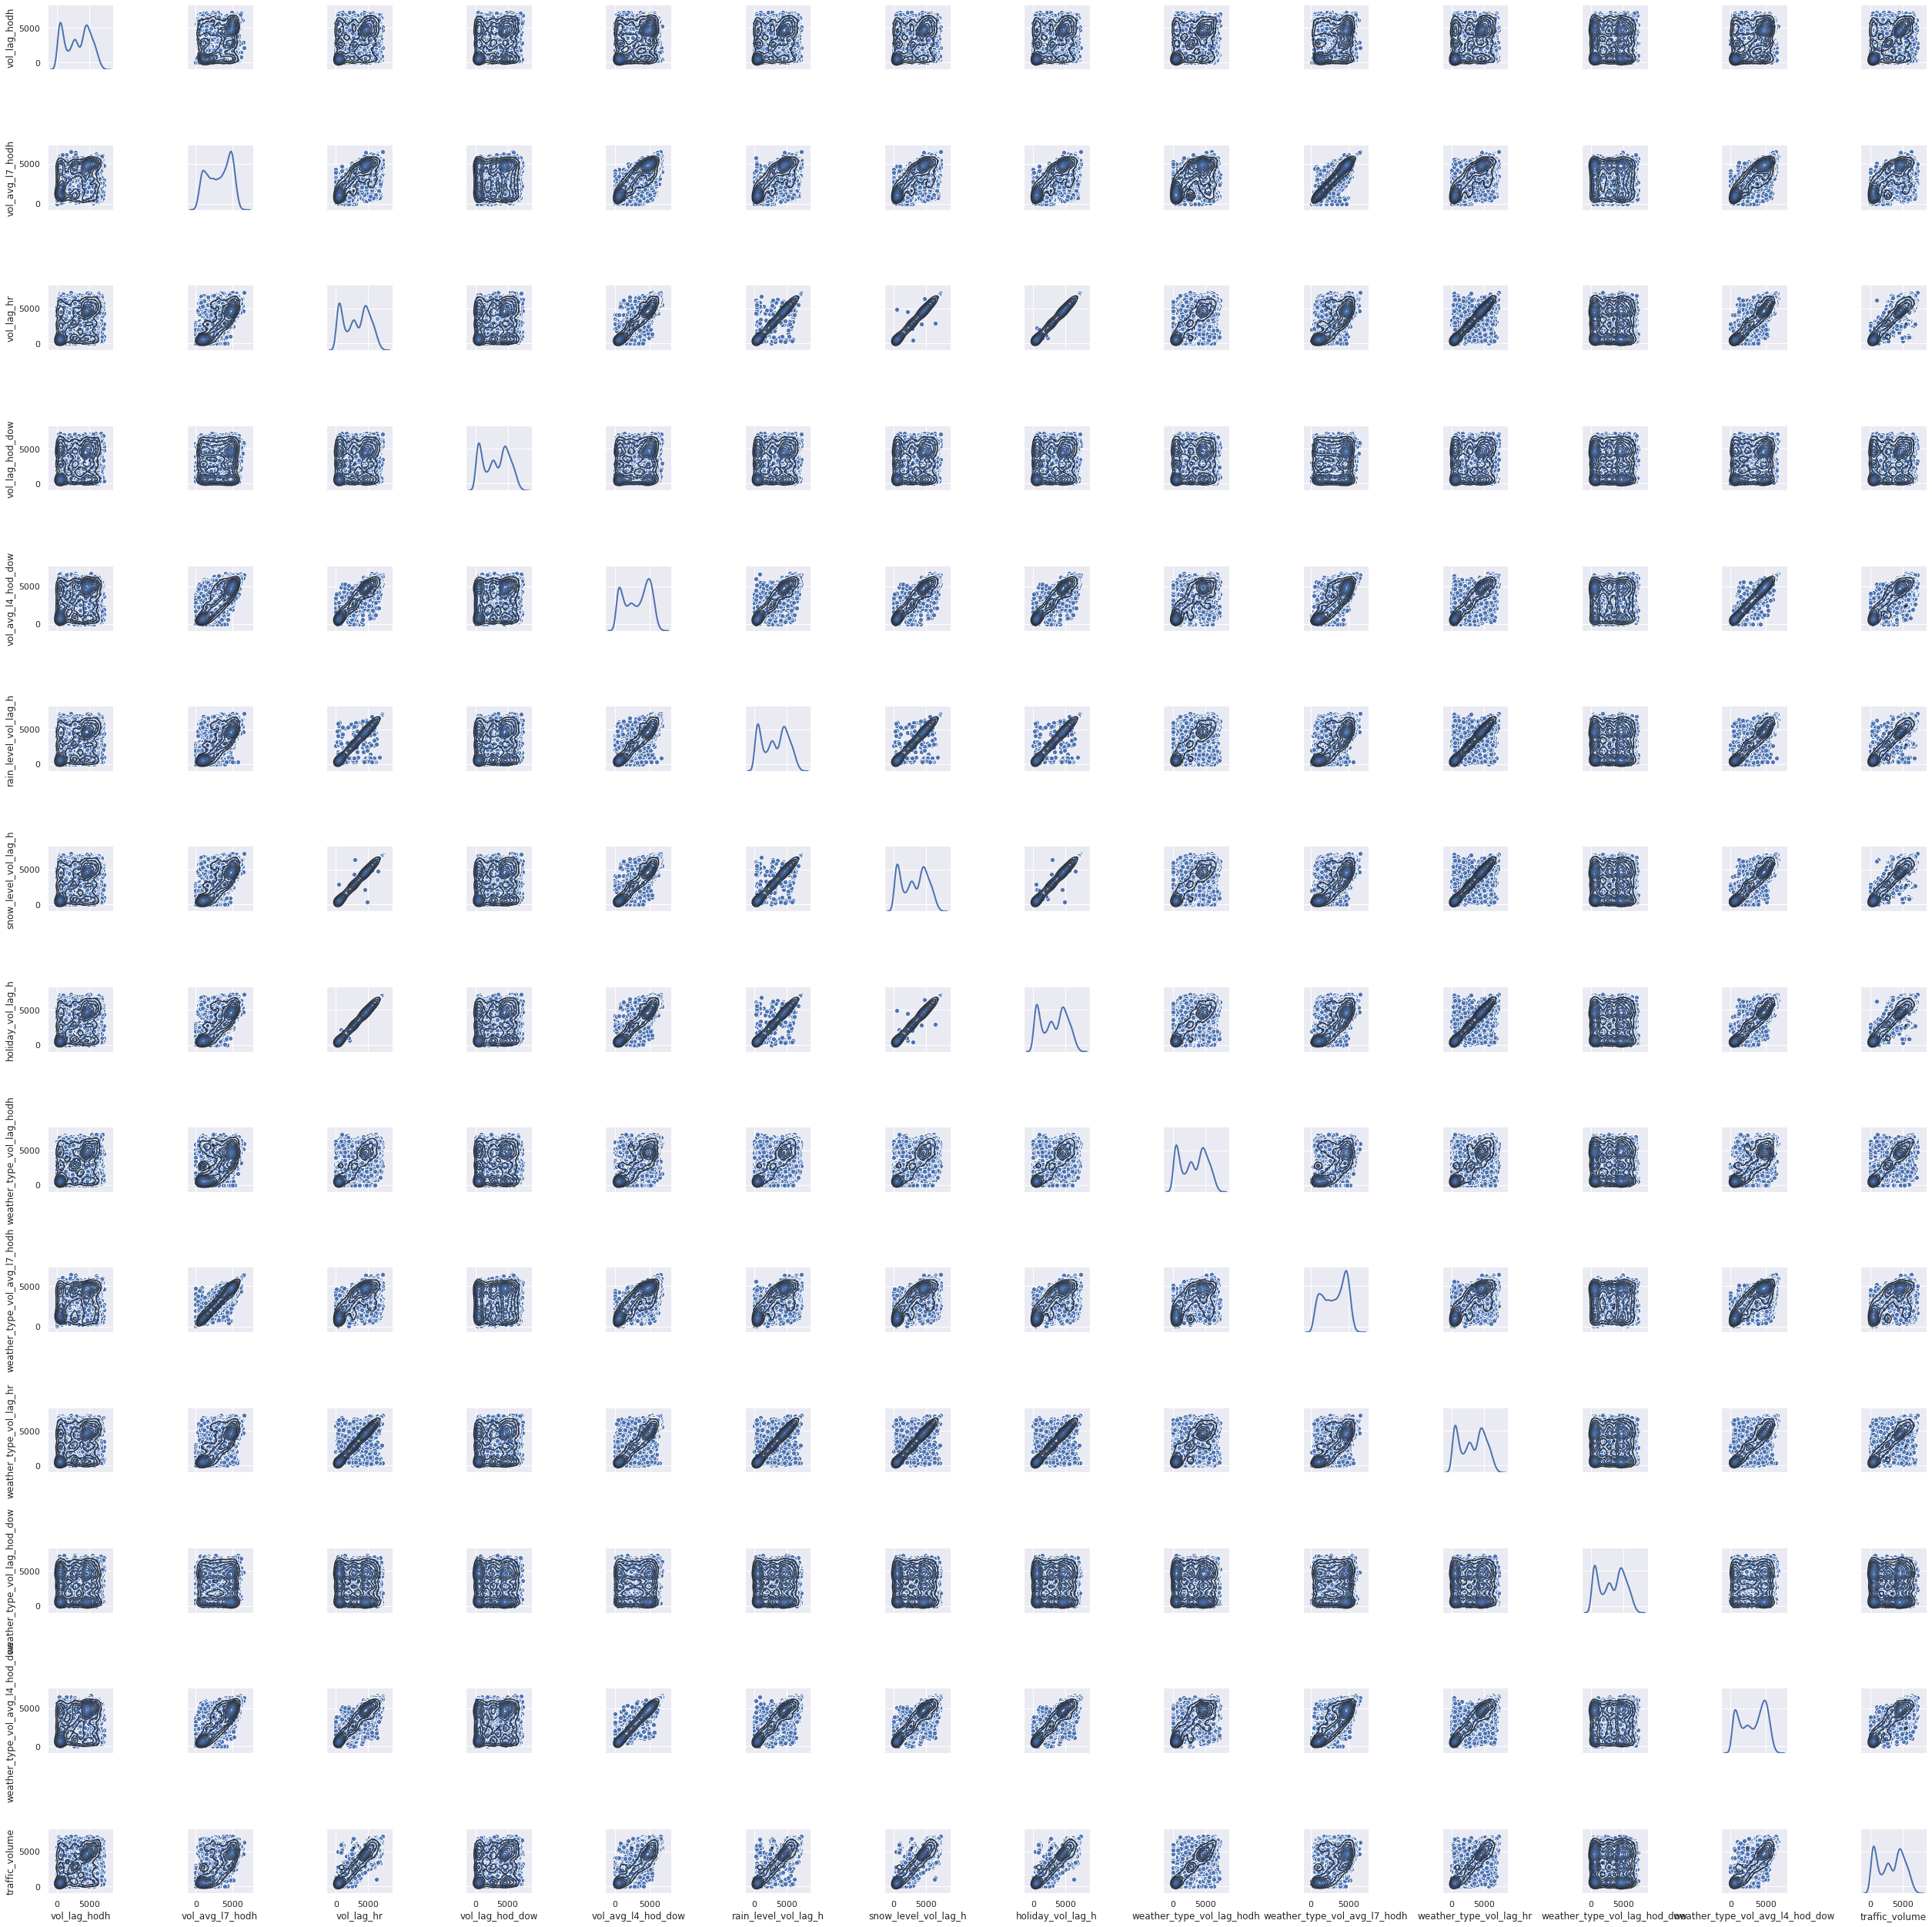

In [100]:
#dayofweek features still lag too much
#add l24h, l1_dow, l1h
traffic_df_sample = traffic_df[traffic_df['year']==2016]
sns.set()
g = sns.PairGrid(traffic_df_sample[non_ordinal_cols_1_sample])
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.scatterplot)
g = g.map_upper(sns.kdeplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=2)

In [101]:
#good bunch for feature validation
regression_label = 'traffic_volume'
features = [x for x in non_ordinal_cols_0 + non_ordinal_cols_1 if x not in [regression_label]]
X, y = traffic_df.drop(columns=regression_label), traffic_df[regression_label]

In [102]:
features

['temp_F',
 'cloud_cover_%',
 'rain_level_vol_avg_to_date',
 'snow_level_vol_avg_to_date',
 'holiday_vol_avg_to_date',
 'weather_type_vol_avg_to_date',
 'hod_vol_avg_to_date',
 'dow_vol_avg_to_date',
 'rain_level_vol_max_to_date',
 'rain_level_vol_min_to_date',
 'snow_level_vol_max_to_date',
 'snow_level_vol_min_to_date',
 'holiday_vol_max_to_date',
 'holiday_vol_min_to_date',
 'weather_type_vol_max_to_date',
 'weather_type_vol_min_to_date',
 'hod_vol_max_to_date',
 'hod_vol_min_to_date',
 'dow_vol_max_to_date',
 'dow_vol_min_to_date',
 'vol_lag_hodh',
 'vol_min_l7_hodh',
 'vol_max_l7_hodh',
 'vol_avg_l7_hodh',
 'vol_std_l7_hodh',
 'vol_lag_hr',
 'vol_lag_hod_dow',
 'vol_min_l4_hod_dow',
 'vol_max_l4_hod_dow',
 'vol_avg_l4_hod_dow',
 'vol_std_l4_hod_dow',
 'rain_level_vol_lag_h',
 'snow_level_vol_lag_h',
 'holiday_vol_lag_h',
 'weather_type_vol_lag_hodh',
 'weather_type_vol_min_l7_hodh',
 'weather_type_vol_max_l7_hodh',
 'weather_type_vol_avg_l7_hodh',
 'weather_type_vol_std_l7_hodh',


In [103]:
len(features)

45

In [104]:
# want to make sure each class repped in test and train set
# cannot stratify by all imbalanced categorical variables, so stratify by smallest one
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=X['holiday'])

In [105]:
rfr = RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=5)
rfr.fit(X_train[features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [106]:
# Use the forest's predict method on the test data
# With good accuracy, we look to eliminate unnecessary features
y_pred = rfr.predict(X_test[features])# Calculate the absolute errors
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)), 'trips.')
print('R2:', r2_score(y_test, y_pred))

RMSE: 551.1939704256635 trips.
R2: 0.9234110276431574


In [107]:
X_eval = X_test
X_eval['y_pred'] = y_pred
X_eval['y_test'] = y_test

/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
X_eval = X_eval.sort_values('date_time')
X_eval

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
847      None   39.04      0.0      0.0             40       Clouds   
982      None   42.51      0.0      0.0             90       Clouds   
993      None   39.25      0.0      0.0             90       Clouds   
1009     None   42.01      0.0      0.0             90       Clouds   
1011     None   44.28      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43691    None   55.40      0.0      0.0              1        other   
43696    None   55.17      0.0      0.0              1        other   
43700    None   59.63      0.0      0.0             40        other   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   

                date_time  year  month  hod  ...  \
847   2012-11-02 18:00:00  2012     11   18  ...   
982   2012-11-07 13:00:00  2012     11   13  ...   
993   2012-11-07 19:00:00  2012     11   19  ...   
1009  2012-11-08 11:00:00  2012     11   11  ...   
1011  2012-11-08 13:00:00  2012     11   13  ...   
...                   ...   ...    ...  ...  ...   
43691 2018-04-30 05:00:00  2018      4    5  ...   
43696 2018-04-30 09:00:00  2018      4    9  ...   
43700 2018-04-30 12:00:00  2018      4   12  ...   
43709 2018-04-30 21:00:00  2018      4   21  ...   
43710 2018-04-30 22:00:00  2018      4   22  ...   

       weather_type_vol_avg_l7_hodh weather_type_vol_std_l7_hodh  \
847                     5601.000000                   533.219780   
982                     4577.857143                  1262.829288   
993                     5295.571429                  1376.565637   
1009                    4276.000000                  1764.034769   
1011                    4516.000000                  1545.746098   
...                             ...                          ...   
43691                   1235.857143                  1134.957625   
43696                   4968.571429                  1497.667170   
43700                   4634.142857                  1456.084754   
43709                   3784.714286                   911.366687   
43710                   3344.571429                  1174.811028   

      weather_type_vol_lag_hr  weather_type_vol_lag_hod_dow  \
847                    5856.0                        4639.0   
982                    5011.0                         330.0   
993                    4889.0                         453.0   
1009                   4670.0                         530.0   
1011                   5246.0                         799.0   
...                       ...                           ...   
43691                  2871.0                         397.0   
43696                  5171.0                         300.0   
43700                  4619.0                        1311.0   
43709                  2673.0                         361.0   
43710                  5034.0                        2736.0   

       weather_type_vol_min_l4_hod_dow  weather_type_vol_max_l4_hod_dow  \
847                             5341.0                           6348.0   
982                             4567.0                           5051.0   
993                             2711.0                           6057.0   
1009                            4619.0                           5892.0   
1011                            4619.0                           5286.0   
...                                ...                              ...   
43691                            779.0                           2871.0   
43696                           4045.0                           6574.0   
43700                           3860.0                           4523.0   
43709                           2197.0                           4388.0   
43710                           1489.0                           3346.0   

       weather_type_vol_avg_l4_hod_dow  weather_type_

(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text xticklabel objects>)

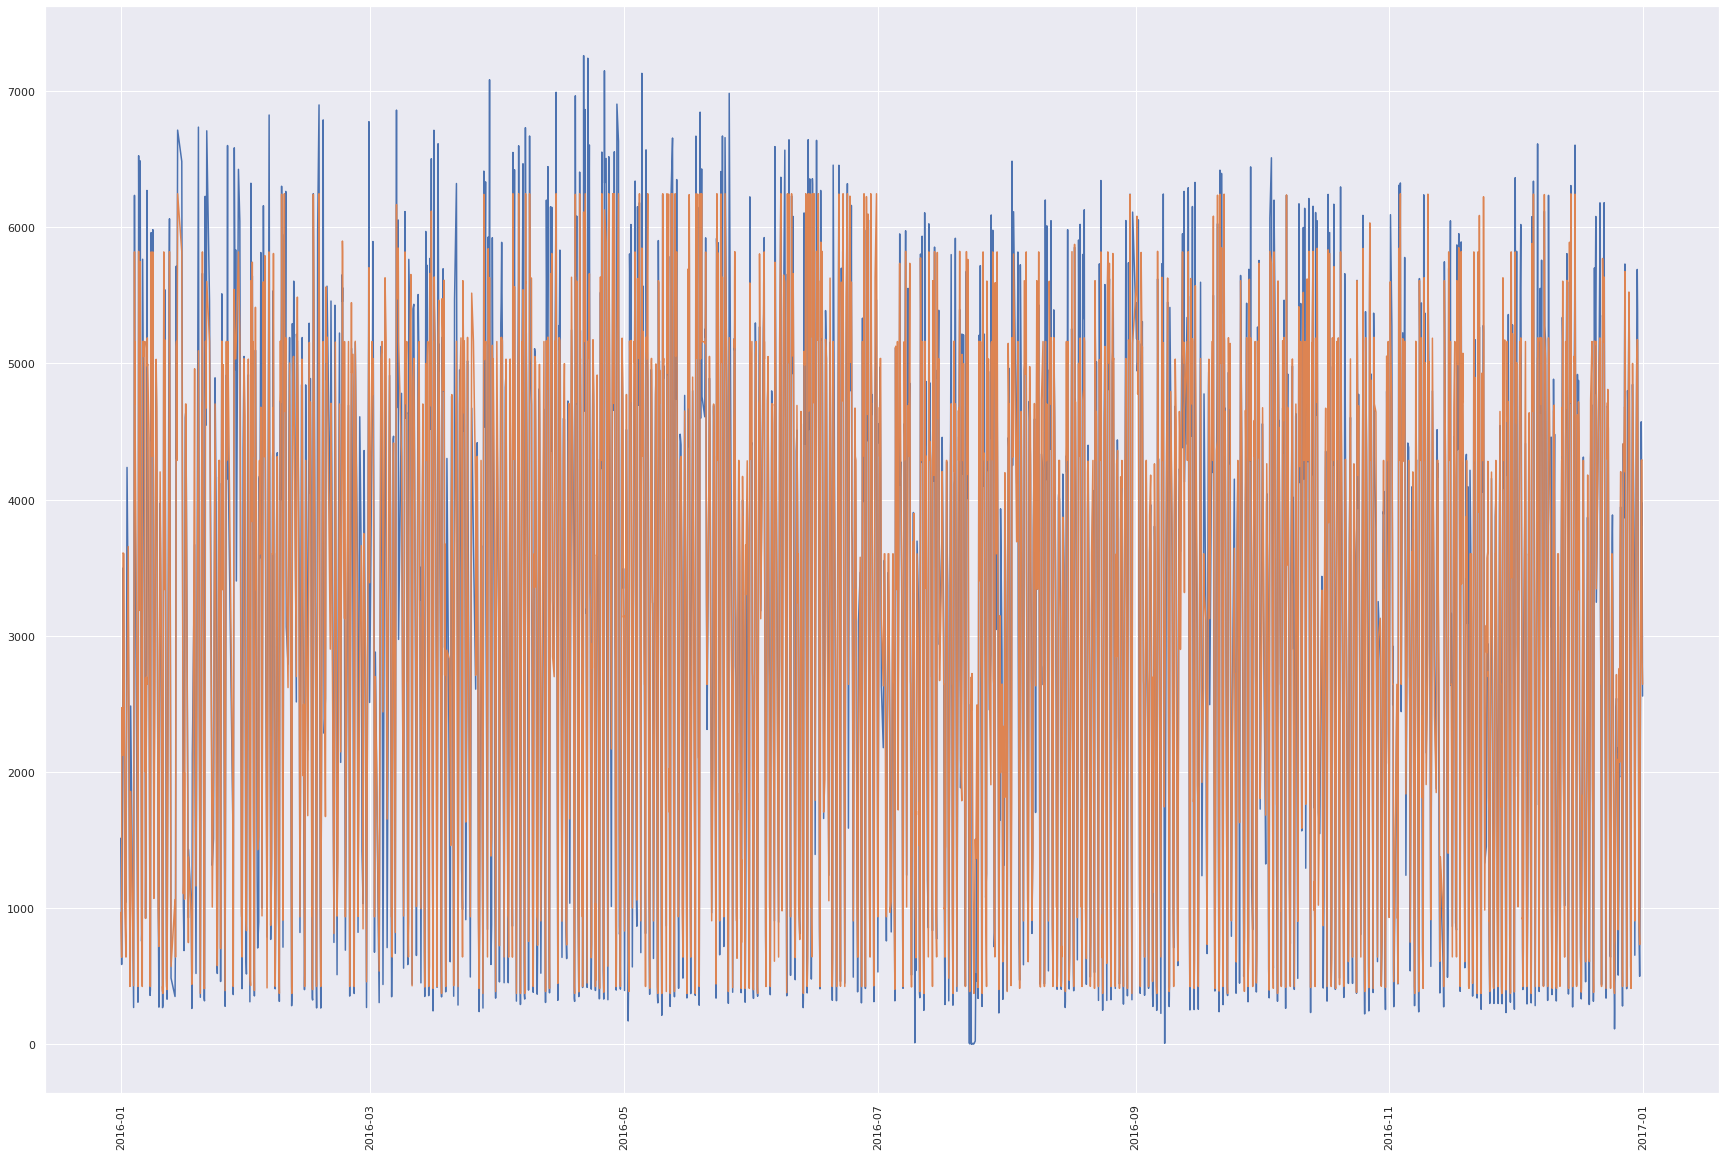

In [109]:
#plot time vs volume, get an idea for the time series

fig = plt.figure(figsize=(30,20))
X_eval_sample = X_eval[X_eval['year']==2016]
plt.plot(X_eval_sample['date_time'], X_eval_sample[['y_test','y_pred']])
plt.xticks(rotation='vertical')

In [110]:
importances = rfr.feature_importances_
importance = pd.DataFrame({"features":features,"importance": importances}).sort_values('importance',ascending=False)

importance["std"] = np.std([tree.feature_importances_
                            for tree in rfr.estimators_], axis=0)

In [111]:
#really only need a handful of variables
#include features like temp, cloud cover anyway for the sake of human intuition / interpretability
#lag_h
#lag_hodh
#l7_hodh
#l4_hod_dow
#avg_to_date
#min_to_date
importance

features    importance       std
25                       vol_lag_hr  4.786498e-01  0.000128
33                holiday_vol_lag_h  3.580934e-01  0.000052
34        weather_type_vol_lag_hodh  7.311847e-02  0.000065
32             snow_level_vol_lag_h  4.102146e-02  0.000055
30               vol_std_l4_hod_dow  1.488764e-02  0.000070
27               vol_min_l4_hod_dow  8.690115e-03  0.000047
44  weather_type_vol_std_l4_hod_dow  6.785393e-03  0.000169
28               vol_max_l4_hod_dow  6.291148e-03  0.000060
42  weather_type_vol_max_l4_hod_dow  3.015174e-03  0.000175
21                  vol_min_l7_hodh  2.747374e-03  0.000016
23                  vol_avg_l7_hodh  2.053948e-03  0.000204
37     weather_type_vol_avg_l7_hodh  1.049765e-03  0.000028
29               vol_avg_l4_hod_dow  8.864916e-04  0.000199
41  weather_type_vol_min_l4_hod_dow  6.581731e-04  0.000016
43  weather_type_vol_avg_l4_hod_dow  4.896962e-04  0.000230
31             rain_level_vol_lag_h  4.189987e-04  0.000011
22                  vol_max_l7_hodh  3.767360e-04  0.000246
35     weather_type_vol_min_l7_hodh  2.696550e-04  0.000012
20                     vol_lag_hodh  1.009644e-04  0.000224
24                  vol_std_l7_hodh  8.584944e-05  0.000024
39          weather_type_vol_lag_hr  4.603757e-05  0.000421
6               hod_vol_avg_to_date  3.576304e-05  0.001979
16              hod_vol_max_to_date  2.983988e-05  0.000810
18              dow_vol_max_to_date  2.341137e-05  0.001719
38     weather_type_vol_std_l7_hodh  2.324994e-05  0.000279
14     weather_type_vol_max_to_date  2.290007e-05  0.360906
36     weather_type_vol_max_l7_hodh  2.287324e-05  0.000013
10       snow_level_vol_max_to_date  2.082549e-05  0.003551
0                            temp_F  1.824522e-05  0.002778
12          holiday_vol_max_to_date  1.690110e-05  0.001206
8        rain_level_vol_max_to_date  1.586905e-05  0.005586
4           holiday_vol_avg_to_date  5.180023e-06  0.000831
1                     cloud_cover_%  5.092346e-06  0.058216
7               dow_vol_avg_to_date  5.091265e-06  0.358113
2        rain_level_vol_avg_to_date  4.996287e-06  0.002518
3        snow_level_vol_avg_to_date  4.109174e-06  0.000620
5      weather_type_vol_avg_to_date  2.140695e-06  0.000165
40     weather_type_vol_lag_hod_dow  2.064260e-06  0.001675
11       snow_level_vol_min_to_date  1.437672e-06  0.000132
19              dow_vol_min_to_date  1.224256e-06  0.000281
13          holiday_vol_min_to_date  8.416891e-07  0.000031
9        rain_level_vol_min_to_date  4.907622e-07  0.001617
26                  vol_lag_hod_dow  4.262223e-07  0.003897
17              hod_vol_min_to_date  3.867387e-07  0.000889
15     weather_type_vol_min_to_date  3.530861e-07  0.005403

In [112]:
important_features = ['holiday_vol_lag_h'
                     ,'vol_lag_hr'
                     ,'weather_type_vol_lag_hodh'
                     ,'vol_std_l4_hod_dow'
                     ,'snow_level_vol_lag_h'
                     ,'rain_level_vol_lag_h'
                     ,'weather_type_vol_max_to_date'
                     ,'dow_vol_avg_to_date'
                     ,'temp_F'
                     ,'cloud_cover_%'
                     ]

In [113]:
def gbtr_model(X, y):
    # perform grid search
    gsc = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid={
            'learning_rate': [.0001, .001, .01, .1, .2, .3]
            , 'max_depth': range(3,10)
            , 'n_estimators': [10, 20, 50, 100, 1000],
        },
        cv=5
        , verbose=0
        , n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    gbtr = GradientBoostingRegressor(learning_rate=best_params["learning_rate"]
                                ,max_depth=best_params["max_depth"]
                                , n_estimators=best_params["n_estimators"]
                                , random_state=42)
    gbtr.fit(X,y)
    return gbtr

In [114]:
gbtr = gbtr_model(X_train[important_features], y_train)

In [115]:
y_pred = gbtr.predict(X_test[important_features])
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)), 'trips.')
print('R2:', r2_score(y_test, y_pred))

RMSE: 478.60061927209756 trips.
R2: 0.9422564023599793


/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text xticklabel objects>)

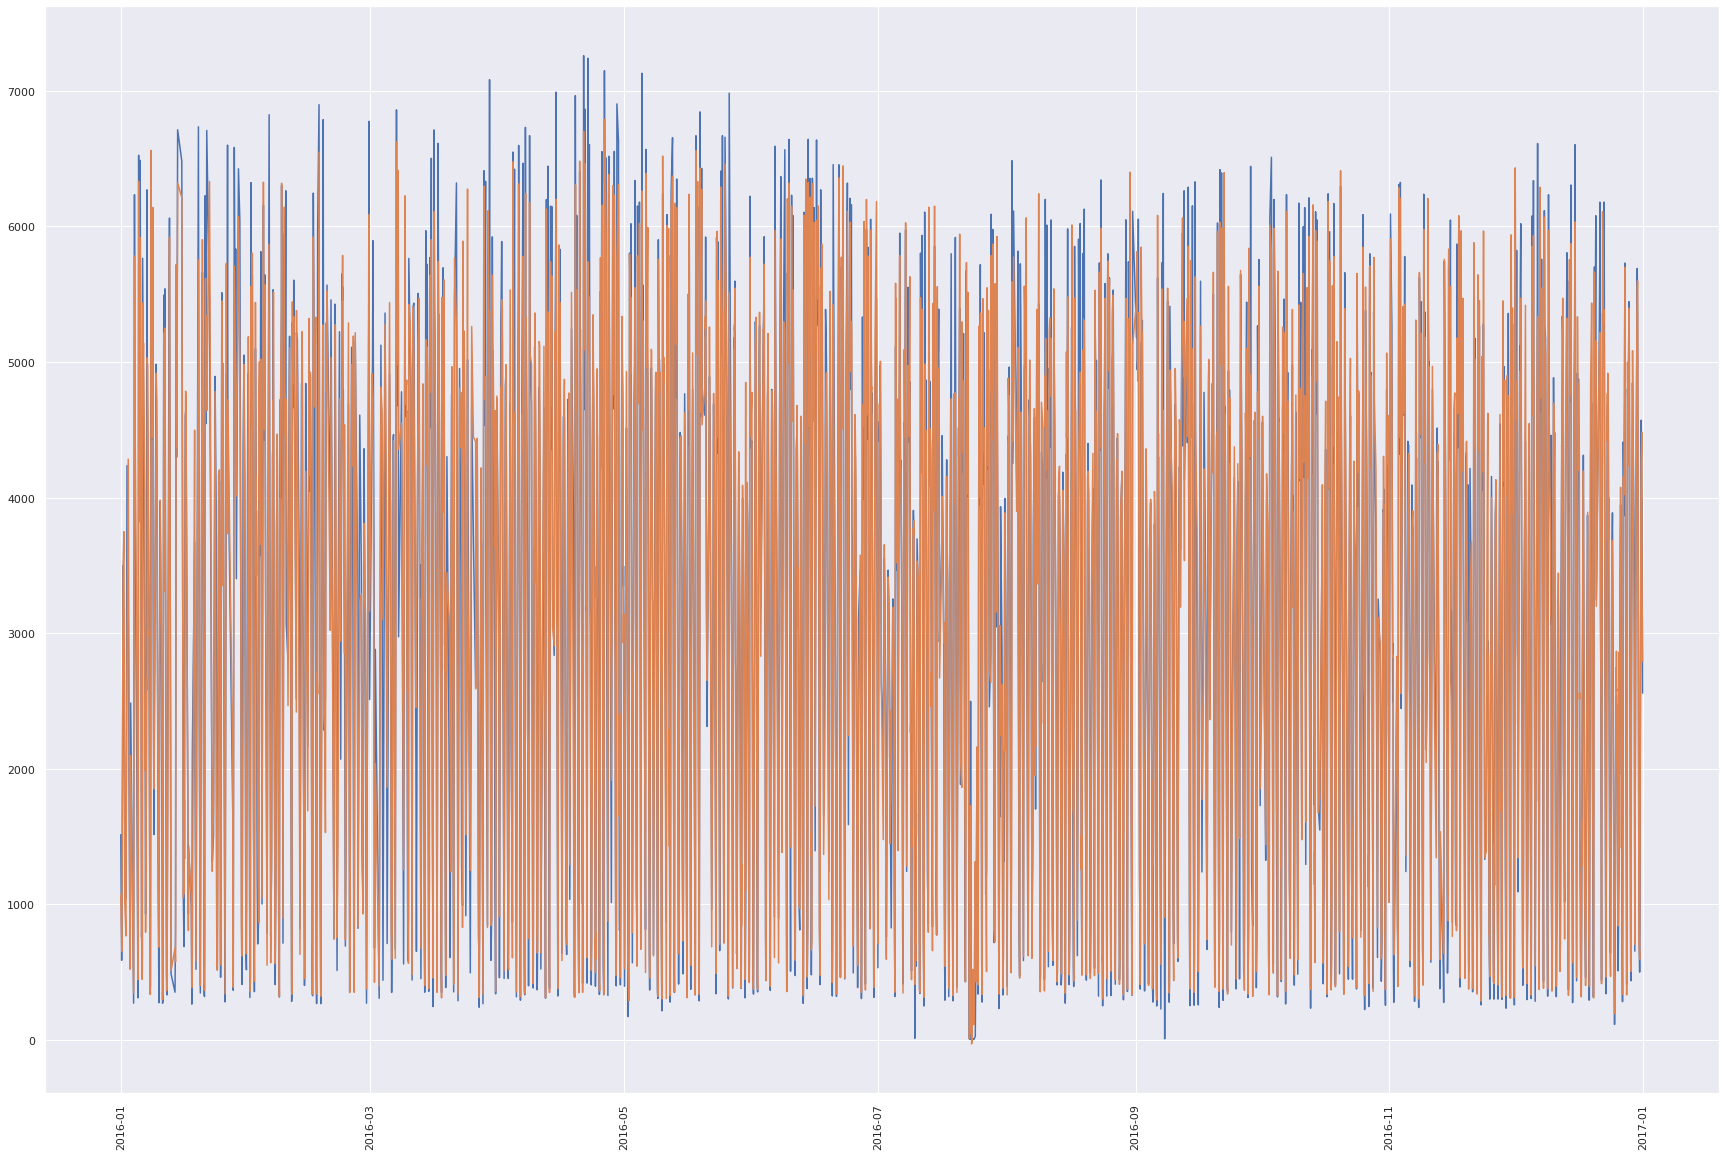

In [116]:
X_eval = X_test
X_eval['y_pred'] = y_pred
X_eval['y_test'] = y_test
X_eval = X_eval.sort_values('date_time')
fig = plt.figure(figsize=(30,20))
X_eval_sample = X_eval[X_eval['year']==2016]
plt.plot(X_eval_sample['date_time'], X_eval_sample[['y_test','y_pred']])
plt.xticks(rotation='vertical')

In [117]:
model_location = 'traffic_volume_model.sav'
pickle.dump(gbtr, open(model_location, 'wb'))

In [118]:
gbtr = pickle.load(open(model_location, 'rb'))

In [119]:
y_pred = gbtr.predict(X_test[important_features])
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)), 'trips.')
print('R2:', r2_score(y_test, y_pred))

RMSE: 478.60061927209756 trips.
R2: 0.9422564023599793
